In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import winsound
from sklearn.preprocessing import StandardScaler

plt.rcParams['figure.figsize'] = [5, 4]

#configuracoes para os plots
plt.rc('axes', titlesize = 15)     # fontsize of the axes title
plt.rc('axes', labelsize = 12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize = 14)    # fontsize of the tick labels
plt.rc('ytick', labelsize = 14)    # fontsize of the tick labels
plt.rc('legend', fontsize = 12)    # legend fontsize

#Classes que englobam os ataques que estao nos dados de treinamento e nos dados de teste
#Classes segundo thinline
#attack_classes = {'dos':['apache2','back','land','mailbomb','neptune','pod','processtable','smurf','teardrop','udpstorm'],
#                  'probe':['ipsweep','mscan','nmap','portsweep','saint','satan'],
#                  'u2r':['buffer_overflow','loadmodule','perl','rootkit','httptunnel','ps','sqlattack','xterm'],
#                  'r2l':['ftp_write','guess_passwd','imap','multihop','phf','spy','warezclient','warezmaster','sendmail','named','snmpgetattack','snmpguess','xlock','xsnoop','worm']}

#Ref: Performance Analysis of NSL-KDD dataset using ANN
attack_classes = {'dos':['apache2','back','land','mailbomb','neptune','pod','processtable','smurf','teardrop','udpstorm'],
                  'probe':['ipsweep','mscan','nmap','portsweep','saint','satan'],
                  'u2r':['buffer_overflow','loadmodule','perl','ps','rootkit','snmpguess','sqlattack','worm','xterm'],
                  'r2l':['spy','warezclient','ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','warezmaster','xlock','xsnoop']}


# Classes e funções auxiliares

In [85]:
def beep():
    frequency = 2500
    duration = 1000
    winsound.Beep(frequency, duration)
    
    
def filterArray(x,y,clusts,cats=None):
    '''
    x: array of features
    y: one-dimensional array of labels
    cluts: one-dimensional array with cluster indexes for each connexion
    Filters arrays x (features) and y (labels) according to different clusters given in cluts. It returns an list in which
    each element is a tuple containing arrays x and y of each cluster and the index of the cluster.
    The function by default returns a dictionary of size n, where n is the number of different clusters. If cats is specified,
    the function return a list only containing the tuples corresponding to the cluster indexes idicated in cats, which should
    be a lista of cluster indexes.
    '''
    if cats is None:
        cats = list(np.unique(clusts))
    arrays = {}
    for cat in cats:
        inds = clusts == cat
        xFilt = x[inds]
        yFilt = y[inds]
        arrays[cat] = (xFilt,yFilt)
    return arrays
    
def printClusters(clusters):
    '''
    clusters: list/array of cluster indexes. Each element corresponds to a connexion.
    The function do the count of clusters of each type and counts the number of attacks and normal connexions in each
    cluster. It then prints a table with these counts.
    '''
    print("N | Count | Normal | Attacks")
    for cluster_i in clusters.keys():
        cluster = clusters[cluster_i]
        (u,counts)  = np.unique(cluster[1], return_counts=True)
        if len(u) == 2:
                tabCount = 4 - int(np.floor(np.log10(len(cluster[1]))))
                tabNorm  = 5 - int(np.floor(np.log10(counts[0])))
                print(cluster_i,"|",len(cluster[1])," "*tabCount + "|",counts[0]," "*tabNorm + "|", counts[1])
        else:
            if u[0] == 0:
                tabCount = 4 - int(np.floor(np.log10(len(cluster[1]))))
                tabNorm  = 5 - int(np.floor(np.log10(counts[0])))
                print(cluster_i,"|",len(cluster[1])," "*tabCount + "|",counts[0]," "*tabNorm + "|", 0)
            else:
                tabCount = 4 - int(np.floor(np.log10(len(cluster[1]))))
                print(cluster_i,"|",len(cluster[1])," "*tabCount + "|",0," "*5 + "|", counts[0])
                
def assClfsToClusters(clusters_train, AR, n_estimators=50, max_depth=20, max_features="sqrt"):
    #Contains the RF classifiers for clusters with more than 25 samples and at least 1 attack sample and 1 normal sample
    km_rf_clfs = {}
    #For all the other clusters, we assign a label according to the class of the majority of the samples 
    km_n_clfs  = {}
    step = 1

    filt_features = filterByAR(AR,0.05)
    
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, random_state=1)

    #Fill km_rf_clfs with Random Forest classifiers for each cluster and km_n_clfs with the corresponding label
    for cluster_i in clusters_train.keys():
        print("Step ",step)

        x = clusters_train[cluster_i][0][filt_features] #features of current cluster
        y = clusters_train[cluster_i][1] #labels of current cluster
        m = len(y) #number of samples in current cluster

        (unique,counts)  = np.unique(y, return_counts=True)

        if m > 25 and len(unique) == 2:
            rf_clf.fit(x,y)
            km_rf_clfs[cluster_i] = rf_clf
        else:
            if m <= 25:
                km_n_clfs[cluster_i] = 1
            elif len(y[y==0]) > len(y[y==1]):
                km_n_clfs[cluster_i] = 0
            else:
                km_n_clfs[cluster_i] = 1

        step += 1
    return (km_rf_clfs,km_n_clfs)


def assClfsToClusters2(clusters_train, n_estimators=50, max_depth=20, max_features="sqrt", random_state=1):
    #Contains the RF classifiers for clusters with more than 25 samples and at least 1 attack sample and 1 normal sample
    km_rf_clfs = {}
    #For all the other clusters, we assign a label according to the class of the majority of the samples 
    km_n_clfs  = {}
    step = 1

    filt_features = features_sc
    
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, random_state=random_state)

    #Fill km_rf_clfs with Random Forest classifiers for each cluster and km_n_clfs with the corresponding label
    for cluster_i in clusters_train.keys():
        print("Step ",step)

        x = clusters_train[cluster_i][0][filt_features] #features of current cluster
        y = clusters_train[cluster_i][1] #labels of current cluster
        m = len(y) #number of samples in current cluster

        (unique,counts)  = np.unique(y, return_counts=True)

        if m > 25 and len(unique) == 2:
            rf_clf.fit(x,y)
            km_rf_clfs[cluster_i] = rf_clf
        else:
            if m <= 25:
                km_n_clfs[cluster_i] = 1
            elif len(y[y==0]) > len(y[y==1]):
                km_n_clfs[cluster_i] = 0
            else:
                km_n_clfs[cluster_i] = 1

        step += 1
    return (km_rf_clfs,km_n_clfs)


def clustersPredict(x,clusters_ind,km_rf_clfs,km_n_clfs):
    
    y_prob = np.ones(np.shape(x)[0])*(-1)
    
    for cluster_i in km_rf_clfs.keys():
        inds = clusters_ind == cluster_i
        y_prob[inds] = km_rf_clfs[cluster_i].predict_proba(x[inds])[:,1]
    
    for cluster_i in km_n_clfs:
        inds = clusters_ind == cluster_i
        y_prob[inds] = km_n_clfs[cluster_i]
        
    return y_prob


def calcAR(df,feature_cols,label_col):
    col_type = getColType(df,list(set(df.columns) - set(feature_cols)))
    labels = list(set(list(df[label_col])))
    AR = {}
    
    for col in col_type['numeric']:
        avg   = df[col].mean()
        crs = []
        if avg == 0:
            AR[col] = 0
            continue
        for label in labels:
            crs.append(df.loc[df[label_col] == label, col].mean() / avg)
        AR[col] = max(crs)
        
    for col in col_type['binary']:
        zero = min(df[col])
        one  = max(df[col])
        crs = []
        for label in labels:
            subset = df.loc[df['class5']==label,col]
            f_zero = np.sum(subset == zero)
            f_one  = np.sum(subset == one)
            if f_zero == 0:
                crs.append(1000.0)
                continue
            crs.append(f_one/f_zero)
        AR[col] = max(crs)
    return AR



def filterByAR(AR,min_ar):
    filtred_features = {}
    for key in AR.keys():
        if AR[key] >= min_ar:
            filtred_features[key] = AR[key]
    return list(filtred_features.keys())
            

def getColType(df,labels_col):
    col_type = {'categorical':[],
                'binary':[],
                'numeric':[]}
    
    for col in list(df.drop(columns=labels_col).columns):
        if df[col].dtype == 'O':
            col_type['categorical'].append(col)
        elif len(list(df[col].value_counts().index)) == 2:
            col_type['binary'].append(col)
        else:
            col_type['numeric'].append(col)
    return col_type

def printMetrics(y_yh,legend):
    metrics = {}
    table = pd.DataFrame()
    i = 0
    for pair in y_yh:
        metrics = []
        metrics.append(accuracy_score(pair[0],pair[1]))
        fpr, tpr, thresholds = roc_curve(pair[0],pair[1])
        metrics += [tpr[1],fpr[1]]
        metrics.append(roc_auc_score(pair[0],pair[1]))
        metrics.append(f1_score(pair[0],pair[1]))
        metrics.append(precision_score(pair[0],pair[1]))
        
        table[legend[i]] = metrics 
        i += 1
    table.index = ["Accuracy", "TPR","FPR", "AUC", "F1 Score", "Precisão"]
    
    return table


def analyseThresholds(y,yprob,thList=None):
    if thList is None:
        thList = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1]
    #metrics = {"f1":[],'prec':[],'tpr':[],'fpr':[],'acc':[],'auc':[]}
    metrics = {"f1":[],'tpr':[],'fpr':[],'acc':[]}
    
    for th in thList:
        ypred = yprob > th
        metrics['acc'].append(accuracy_score(y,ypred))
        fpr, tpr, thresholds = roc_curve(y,ypred)
        metrics['tpr'].append(tpr[1])
        metrics['fpr'].append(fpr[1])
       # metrics['auc'].append(roc_auc_score(y,ypred))
        metrics['f1'].append(f1_score(y,ypred))
        #metrics['prec'].append(precision_score(y,ypred))
    y = np.array(list(metrics.values())).T
    plt.semilogx(thList,y,linewidth=2)
    plt.grid()
    #plt.legend(['F1','Prec','TPR','FPR','Acc','AuC'])
    plt.legend(['F1','TPR','FPR','Acurácia'])
    plt.xlabel('Limiar de detecção')

# Importing Data

Os nomes de cada coluna (feauture) não vieram diretamente no arquivo dos dados, então eles foram inseridos manualmente.

In [86]:
pd.set_option('display.max_columns', None)
pd.reset_option('max_rows')

headers = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 
           'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
           'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
           'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
           'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
           'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
           'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
           'dst_host_srv_rerror_rate','event_type','event_score']\

labels = ['event_type','event_score']

df_train = pd.read_csv("NSL-KDD/KDDTrain+.txt",names=headers)
df_test = pd.read_csv("NSL-KDD/KDDTest+.txt",names=headers)

col_type = getColType(df_train,labels)
    

In [87]:
len(col_type['numeric'])

33

In [88]:
num = len(col_type['numeric'])
cat = len(col_type['categorical'])
bny = len(col_type['binary'])
num + cat + bny

41

In [89]:
len(list(df_train['event_type'].value_counts()))

23

In [90]:
col_type['categorical']

['protocol_type', 'service', 'flag']

In [91]:
c = 0
for col in col_type['categorical']:
    x = len(df_train[col].value_counts())
    print(x)
    c += x
print(c)

3
70
11
84


# Preprocessing Data

In this step, we add the columns <b>class5</b> (labels belonging to 5 different classes: normal, DoS, probe, U2R or R2L) and <b>class2</b> (labels belonging to 2 different classes: normal or attack).

In [92]:
df_train = df_train.drop(labels='event_score',axis=1)
df_test  = df_test.drop(labels='event_score',axis=1)

event_train = df_train['event_type']
event_test = df_test['event_type']
(df_train['class5'],df_test['class5']) = (0,0)
(df_train.loc[event_train.isin(attack_classes['dos']), 'class5'],df_test.loc[event_test.isin(attack_classes['dos']), 'class5']) = (1,1)
(df_train.loc[event_train.isin(attack_classes['probe']), 'class5'],df_test.loc[event_test.isin(attack_classes['probe']), 'class5']) = (2,2)
(df_train.loc[event_train.isin(attack_classes['u2r']), 'class5'],df_test.loc[event_test.isin(attack_classes['u2r']), 'class5']) = (3,3)
(df_train.loc[event_train.isin(attack_classes['r2l']), 'class5'],df_test.loc[event_test.isin(attack_classes['r2l']), 'class5']) = (4,4)

(df_train['class2'],df_test['class2']) = (0,0)
(df_train.loc[event_train != 'normal', 'class2'] ,df_test.loc[event_test != 'normal', 'class2']) = (1,1)

if not('class2') in labels:
    labels.extend(['class2','class5'])
    labels.remove('event_score')

In [93]:
#This cell is dedicated to printing the table with different counts, shown below
gen_dict = {'Total': [len(df_train),len(df_test)],
            'Normal':[np.sum(df_train.class2 == 0),np.sum(df_test.class2 == 0)],
            'Attack':[np.sum(df_train.class2 == 1),np.sum(df_test.class2 == 1)],
            'DoS':   [np.sum(df_train.class5 == 1),np.sum(df_test.class5 == 1)],
            'Probe': [np.sum(df_train.class5 == 2),np.sum(df_test.class5 == 2)],
            'U2R':   [np.sum(df_train.class5 == 3),np.sum(df_test.class5 == 3)],
            'R2L':   [np.sum(df_train.class5 == 4),np.sum(df_test.class5 == 4)]}
gen_table = pd.DataFrame(data=gen_dict,index=['Train','Test'])
gen_table

,Total,Normal,Attack,DoS,Probe,U2R,R2L
Train,125973,67343,58630,45927,11656,52,995
Test,22544,9711,12833,7458,2421,400,2554


Abaixo, observamos a contagem de elementos na coluna <i>su_attempted</i>. Essa coluna indica se o comando "su_root" foi usado ou não. Portanto, essa coluna deveria conter apenas valores 0 ou 1, porém, vemos que alguns valores são iguais a 2. Isso será corrigido mais para frente.

# Preparação dos Dados

Eliminamos a coluna <i>num_outbound_cms</i>, pois todos seus valores são iguais a zero.

In [94]:
if 'num_outbound_cmds' in df_train.columns:
    del df_train['num_outbound_cmds']
    col_type['numeric'].remove('num_outbound_cmds')
if 'num_outbound_cmds' in df_test.columns:
    del df_test['num_outbound_cmds']

Corrigimos a coluna <i>su_attempted</i>, substituindo os valores iguais a 2 por 1.

In [95]:
df_train['su_attempted'] = df_train['su_attempted'].replace(2,1)
df_test['su_attempted']  = df_test['su_attempted'].replace(2,1)

if 'su_attempted' in col_type['numeric'] and not('su_attempted' in col_type['binary']):
    col_type['binary'].append('su_attempted')
    col_type['numeric'].remove('su_attempted')

Nessa parte é realizada uma codificação one-hot nas colunas com valores string e os valores foram normalizados.
Nos dados de treinamento, agora, existem 6 features que não existem nos dados de teste. Isso aconteceu porque quando foi feito o one-hot encoding, alguns labels não existiam nos dados de test. São os labels mostrados abaixo (todos da coluna service).

In [96]:
from sklearn.model_selection import train_test_split

#we apply one-hot encoding to the trainning dataset
df_train_ohe = pd.get_dummies(df_train,columns=['protocol_type','service','flag'])

#we apply one-hot encoding to the test dataset and we add the 6 columns that were missing
df_test_ohe  = pd.get_dummies(df_test,columns=['protocol_type','service','flag'])
df_test_ohe[['service_http_2784', 'service_harvest', 'service_aol', 'service_http_8001', 'service_urh_i', 'service_red_i']] = 0

#list of features of the dataset after apply one-hot econding
features_ohe = list(df_train_ohe.columns)[:]
for col in labels:
    features_ohe.remove(col)

#column type (numeric, categorical, binary) after applyign one-hot encoding
col_type_ohe = getColType(df_train_ohe,labels)

A cross validation dataset is created by splitting the trainning dataset (20% for cross validation).


In [165]:
from sklearn.model_selection import train_test_split

df_train_complete = df_train_ohe
df_train_ohe_split, df_cv_ohe_split = train_test_split(df_train_ohe, test_size=0.2, random_state=1)
df_train_ohe_split.index = range(len(df_train_ohe_split.index))
df_cv_ohe_split.index = range(len(df_cv_ohe_split.index))

In [168]:
#standardization of the features of both datasets
ft_train_complete = pd.DataFrame(StandardScaler().fit_transform(df_train_complete[features_ohe]),columns=features_ohe)
ft_train = pd.DataFrame(StandardScaler().fit_transform(df_train_ohe_split[features_ohe]),columns=features_ohe)
ft_cv    = pd.DataFrame(StandardScaler().fit_transform(df_cv_ohe_split[features_ohe]),columns=features_ohe)
ft_test  = pd.DataFrame(StandardScaler().fit_transform(df_test_ohe[features_ohe]),columns=features_ohe)

#concatenation of the standardized features with the label columns
df_train_complete_sc = pd.concat([ft_train_complete, df_train_complete[labels]],axis=1)
df_train_sc = pd.concat([ft_train,df_train_ohe_split[labels]],axis=1)
df_cv_sc    = pd.concat([ft_cv,df_cv_ohe_split[labels]],axis=1)
df_test_sc  = pd.concat([ft_test,df_test_ohe[labels]],axis=1)

In this part, we index the binary features with ones and zeros, since these binary columns were standardized and are no longer 0's and 1's.

In [170]:
for col in col_type_ohe['binary']:
    zero_train_complete = min(df_train_complete[col])
    one_train_complete = max(df_train_complete[col])
    (zero_train, zero_cv, zero_test) = (min(df_train_sc[col]), min(df_cv_sc[col]), min(df_test_sc[col]))
    (one_train, one_cv, one_test)   = (max(df_train_sc[col]), max(df_cv_sc[col]), max(df_test_sc[col]))
    
    df_train_complete.loc[df_train_complete[col] == zero_train_complete, col] = 0
    df_train_complete.loc[df_train_complete[col] == one_train_complete, col] = 1
    
    df_train_sc.loc[df_train_sc[col] == zero_train, col] = 0
    df_train_sc.loc[df_train_sc[col] == one_train, col] = 1
    
    df_cv_sc.loc[df_cv_sc[col] == zero_cv, col] = 0
    df_cv_sc.loc[df_cv_sc[col] == one_cv, col] = 1
    
    df_test_sc.loc[df_test_sc[col] == zero_test, col] = 0
    df_test_sc.loc[df_test_sc[col] == one_test, col] = 1

In [100]:
features_sc = df_train_sc.columns[:-3]

We filter the features by AR.

In [101]:
AR = calcAR(df_train_ohe,list(set(df_train_sc) - set(labels)),'class5')
filtered_features = filterByAR(AR,0.01)

In [102]:
df_train_ar = df_train_sc[filtered_features + labels]
df_test_ar  = df_test_sc[filtered_features + labels]
df_cv_ar    = df_cv_sc[filtered_features + labels]

In [103]:
table = pd.DataFrame(columns=['Train','CV'])
table.Train = df_train_ar.class5.value_counts()
table.CV = df_cv_ar.class5.value_counts()
table

,Train,CV
0,53837,13506
1,36811,9116
2,9311,2345
4,780,215
3,39,13


# K-means + Random Forest

In [73]:
teste_sil_2_35 = [0.345006653916503,0.43457084078340713,0.4350530079762922,0.3972531354158582,0.42595907479946266,0.4431735685964169,0.46315781392748007,0.4519112378745238,0.45911970788613665,0.4601580885576937,0.4798464537178712,0.46901061850464726,0.478343282547524,0.47812804863688757,0.4044085346878842,0.40414038021754095,0.4666039894421404,0.4237298071040939,0.4591154731351199,0.4303962388878283,0.44725749688593053,0.4509163120029411,0.4703380444019492,0.47452328163406166,0.4789467227714052,0.4747818717933019,0.4910647689478142,0.4842026466332759,0.49412654377128135,0.3653044495613914,0.3700324280067244,0.369280051926834,0.3702808750746112]

In [ ]:
testes_sil_2_11 =[0.345006653916503, 0.43457084078340713, 0.4350530079762922, 0.3972531354158582, 0.42595907479946266, 0.4431735685964169, 0.46315781392748007, 0.4519112378745238, 0.45911970788613665, 0.4601580885576937]

In [40]:
def elbowCurve(kmin,kmax):
    print('ok')
    inertias = []
    (x_train_KM, y_train_KM) = (df_train_sc[features_sc], df_train_sc['class2'])
    K = 25
    for k in range(kmin,kmax):
        print(k)
        kmeans = KMeans(n_clusters = k, max_iter=100, n_init=25, algorithm='full',random_state=1)
        kmeans.fit(x_train_KM)
        inertias.append(kmeans.inertia_)
    plt.plot(range(kmin,kmax), inertias)
    plt.grid()
    return inertias

In [60]:
from sklearn.metrics import silhouette_score
def silhouetteCurve(kmin,kmax):
    print('ok')
    sil = []
    (x_train_KM, y_train_KM) = (df_train_sc[features_sc], df_train_sc['class2'])
    K = 25
    for k in range(kmin,kmax):
        print(k)
        kmeans = KMeans(n_clusters = k, max_iter=100, n_init=25, algorithm='full',random_state=1)
        kmeans.fit(x_train_KM)
        print(len(kmeans.labels_))
        sil.append(silhouette_score(x_train_KM, kmeans.labels_))
    plt.plot(range(kmin,kmax), sil)
    plt.grid()
    return sil    

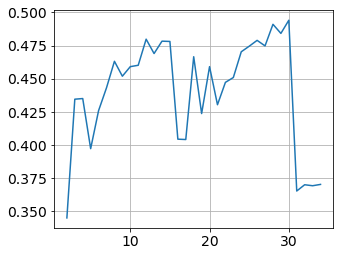

In [109]:
plt.plot(range(2,35),teste_sil_2_35)
plt.grid()

## K-means

In [118]:
from sklearn.cluster import KMeans

(x_train_KM, y_train_KM) = (df_train_sc[features_sc], df_train_sc['class2'])
(x_cv_KM, y_cv_KM) = (df_cv_sc[features_sc], df_cv_sc['class2'])
(x_test_KM, y_test_KM) = (df_test_sc[features_sc], df_test_sc['class2'])

#random_state = 1 -> bad results
#random_state = 10 -> good results
#12 clusters: 3000, 23478
#8 clusters: 10,
kmeans = KMeans(n_clusters = 8, max_iter=50, n_init=35, algorithm='full',random_state = 10)#,random_state=1)#, random_state=10) 
kmeans.fit(x_train_KM)
kmeans.n_iter_

7

In [119]:
clusters_train_ind = kmeans.predict(x_train_KM)
clusters_cv_ind    = kmeans.predict(x_cv_KM)
clusters_test_ind  = kmeans.predict(x_test_KM)

clusters_train = filterArray(df_train_sc, y_train_KM, clusters_train_ind)
clusters_cv    = filterArray(df_cv_sc,    y_cv_KM,    clusters_cv_ind)
clusters_test  = filterArray(df_test_sc,  y_test_KM , clusters_test_ind)

#prints a table with the counts for each cluster
print("Counts for each cluster:",'\n')
print("==== Trainning dataset ====")
printClusters(clusters_train)

print('\n',"==== Test dataset ====")
printClusters(clusters_test)

Counts for each cluster: 

==== Trainning dataset ====
N | Count | Normal | Attacks
0 | 27928 | 64     | 27864
1 | 35779 | 34890  | 889
2 | 12013 | 2235   | 9778
3 | 3749  | 380    | 3369
4 | 1     | 1      | 0
5 | 7379  | 5422   | 1957
6 | 699   | 0      | 699
7 | 13230 | 10845  | 2385

 ==== Test dataset ====
N | Count | Normal | Attacks
0 | 2352  | 13     | 2339
1 | 10129 | 7554   | 2575
2 | 4578  | 70     | 4508
3 | 464   | 61     | 403
5 | 1491  | 948    | 543
6 | 62    | 41     | 21
7 | 3468  | 1024   | 2444


## Random Forest

In [120]:
from sklearn.ensemble import RandomForestClassifier

#Assigns Random Tree classifieers to category 1 clusters and 1 or 0 to category 2 clusters
#km_rf_clfs: dictionary with category 1 clusters, containing Random Tree classifiers
#km_n_clfs: dictionary  with category 2 clusters, containing 1 or 0, depending on majority rule
(km_rf_clfs_train,km_n_clfs_train) = assClfsToClusters2(clusters_train,max_depth=20,n_estimators=400)
(km_rf_clfs_cv,km_n_clfs_cv)       = assClfsToClusters2(clusters_cv,max_depth=20,n_estimators=400)
(km_rf_clfs_test,km_n_clfs_test)   = assClfsToClusters2(clusters_test,max_depth=20,n_estimators=400)

beep()

Step  1
Step  2
Step  3
Step  4
Step  5
Step  6
Step  7
Step  8
Step  1
Step  2
Step  3
Step  4
Step  5
Step  6
Step  7
Step  1
Step  2
Step  3
Step  4
Step  5
Step  6
Step  7


In [121]:
yprob_train_KM = clustersPredict(x_train_KM, clusters_train_ind, km_rf_clfs_train,km_n_clfs_train)
yprob_cv_KM  = clustersPredict(x_cv_KM, clusters_cv_ind, km_rf_clfs_cv,km_n_clfs_cv)
yprob_test_KM  = clustersPredict(x_test_KM, clusters_test_ind, km_rf_clfs_test,km_n_clfs_test)

Metric analyses for the CV dataset for different thresholds:

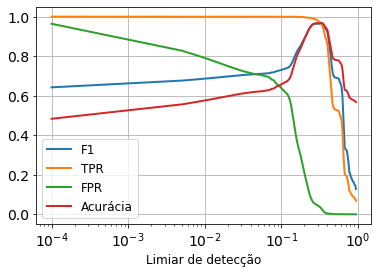

In [126]:
%matplotlib inline

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score

#analyseThresholds(y_train_KM,yprob_train_KM,np.arange(1e-4,0.95,5e-3))
analyseThresholds(y_cv_KM,yprob_cv_KM,np.arange(1e-4,0.95,5e-3))
#analyseThresholds(y_test_KM,yprob_test_KM,np.arange(1e-4,0.95,5e-3))

In [123]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score

ypred_train_KM = yprob_train_KM > 0.3
ypred_cv_KM  = yprob_cv_KM > 0.3
ypred_test_KM  = yprob_test_KM > 0.3
    
beep()
printMetrics([(y_train_KM,ypred_train_KM),(y_cv_KM,ypred_cv_KM),(y_test_KM,ypred_test_KM)],["Trainning","CV","Test"])

,Trainning,CV,Test
Accuracy,0.968118,0.967097,0.946194
TPR,0.980060,0.980666,0.978103
FPR,0.042294,0.044647,0.095974
AUC,0.968883,0.968009,0.941065
F1 Score,0.966258,0.965102,0.953908
Precisão,0.952840,0.950025,0.930881


# Classificação por Classe

## Random Forest

### DoS

In [132]:
mask_dos = (df_train_ohe_split.class5 == 1) | (df_train_ohe_split.class5 == 0)    

(x_train_dos, y_train_dos) = (df_train_sc.loc[:, features_sc], df_train_sc.loc[:,'class2'])

(x_cv_dos, y_cv_dos) = (df_cv_sc.loc[:, features_sc], df_cv_sc.loc[:,'class2'])

(x_test_dos, y_test_dos) = (df_test_sc.loc[:, features_sc], df_test_sc.loc[:,'class2'])

In [133]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=400, max_depth=20, random_state=1)
rf_clf.fit(x_train_dos.loc[mask_dos],y_train_dos.loc[mask_dos])

beep()

In [134]:
yprob_train_dos = rf_clf.predict_proba(x_train_dos)[:,1]
yprob_cv_dos    = rf_clf.predict_proba(x_cv_dos)[:,1]
yprob_test_dos  = rf_clf.predict_proba(x_test_dos)[:,1]

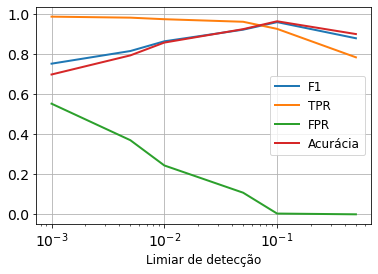

In [107]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score

#Metric analyses for the cv dataset for different thresholds
%matplotlib inline
analyseThresholds(y_cv_dos,yprob_cv_dos)

In [108]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score

yh_train_dos = yprob_train_dos > 0.5
yh_cv_dos    = yprob_cv_dos > 0.3
yh_test_dos  = yprob_test_dos > 0.3

printMetrics([(y_train_dos,yh_train_dos),(y_cv_dos,yh_cv_dos),(y_test_dos,yh_test_dos)],["Trainning","CV","Test"])

,Trainning,CV,Test
Accuracy,0.921967,0.924429,0.741749
TPR,0.832513,0.837197,0.601029
FPR,0.000037,0.000074,0.072289
AUC,0.916238,0.918562,0.764370
F1 Score,0.908582,0.911343,0.725998
Precisão,0.999949,0.999898,0.916578


### Probe

In [109]:
mask_probe = (df_train_ohe.class5 == 2) | (df_train_ohe.class5 == 0)

(x_train_probe, y_train_probe) = (df_train_sc.loc[:, features_sc], df_train_sc.loc[:,'class2'])

(x_cv_probe, y_cv_probe) = (df_cv_sc.loc[:, features_sc], df_cv_sc.loc[:,'class2'])

(x_test_probe, y_test_probe) = (df_test_sc.loc[:, features_sc], df_test_sc.loc[:,'class2'])

In [110]:
from sklearn.ensemble import RandomForestClassifier

rf_clf_probe = RandomForestClassifier(n_estimators=400, max_depth=20, max_features="sqrt", random_state=1)
rf_clf_probe.fit(x_train_probe.loc[mask_probe],y_train_probe[mask_probe])

beep()

In [111]:
yprob_train_probe = rf_clf_probe.predict_proba(x_train_probe)[:,1]
yprob_cv_probe    = rf_clf_probe.predict_proba(x_cv_probe)[:,1]
yprob_test_probe  = rf_clf_probe.predict_proba(x_test_probe)[:,1]

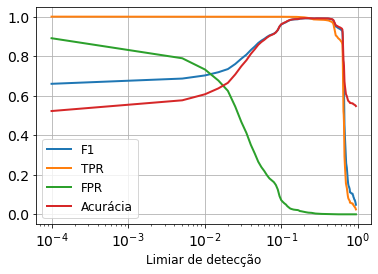

In [112]:
#Metric analyses for the cv dataset for different thresholds
%matplotlib inline
analyseThresholds(y_cv_probe,yprob_cv_probe,np.arange(1e-4,0.95,5e-3))

In [113]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score

yh_train_probe = yprob_train_probe > 0.5
yh_cv_probe    = yprob_cv_probe > 0.2
yh_test_probe  = yprob_test_probe > 0.27

printMetrics([(y_train_probe,yh_train_probe),(y_cv_probe,yh_cv_probe),(y_test_probe,yh_test_probe)],["Trainning","CV","Test"])

,Trainning,CV,Test
Accuracy,0.999286,0.992102,0.852422
TPR,0.998743,0.996407,0.912102
FPR,0.000241,0.011624,0.226444
AUC,0.999251,0.992391,0.842829
F1 Score,0.999233,0.991529,0.875566
Precisão,0.999723,0.986699,0.841844


### U2R + R2L

In [114]:
mask_u2r_r2l = (df_train_ohe.class5 == 3) | (df_train_ohe.class5 == 4) | (df_train_ohe.class5 == 0)

(x_train_u2r_r2l, y_train_u2r_r2l) = (df_train_sc.loc[:, features_sc], df_train_sc.loc[:,'class2'])

(x_cv_u2r_r2l, y_cv_u2r_r2l) = (df_cv_sc.loc[:, features_sc], df_cv_sc.loc[:,'class2'])

(x_test_u2r_r2l, y_test_u2r_r2l) = (df_test_sc.loc[:, features_sc], df_test_sc.loc[:,'class2'])

In [115]:
from sklearn.ensemble import RandomForestClassifier

rf_clf_u2r_r2l = RandomForestClassifier(n_estimators=400, max_depth=20, max_features="sqrt", random_state=1)
rf_clf_u2r_r2l.fit(x_train_u2r_r2l.loc[mask_u2r_r2l],y_train_u2r_r2l.loc[mask_u2r_r2l])

beep()

In [116]:
yprob_train_u2r_r2l = rf_clf_u2r_r2l.predict_proba(x_train_u2r_r2l)[:,1]
yprob_cv_u2r_r2l    = rf_clf_u2r_r2l.predict_proba(x_cv_u2r_r2l)[:,1]
yprob_test_u2r_r2l  = rf_clf_u2r_r2l.predict_proba(x_test_u2r_r2l)[:,1]

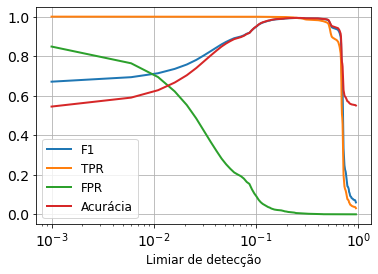

In [117]:
#Metric analyses for the cv dataset for different thresholds
%matplotlib inline
analyseThresholds(y_cv_u2r_r2l,yprob_cv_u2r_r2l,np.arange(1e-3,0.95,5e-3))

In [118]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score

yh_train_u2r_r2l = yprob_train_u2r_r2l > 0.5
yh_cv_u2r_r2l    = yprob_cv_u2r_r2l > 0.33
yh_test_u2r_r2l  = yprob_test_u2r_r2l > 0.33

printMetrics([(y_train_u2r_r2l,yh_train_u2r_r2l),(y_cv_u2r_r2l,yh_cv_u2r_r2l),(y_test_u2r_r2l,yh_test_u2r_r2l)],["Trainning","CV","Test"])

,Trainning,CV,Test
Accuracy,0.999166,0.991546,0.844615
TPR,0.998509,0.984858,0.855762
FPR,0.000260,0.002665,0.170116
AUC,0.999124,0.991096,0.842823
F1 Score,0.999105,0.990834,0.862449
Precisão,0.999701,0.996883,0.869242


### Combination of classifiers

In [119]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

eventClasses = ['Normal','R2L']
eventClassesInd = [0,1]

y_train_comb_prob = (yprob_train_dos + yprob_train_probe + yprob_train_u2r_r2l)/3
y_cv_comb_prob    = (yprob_cv_dos + yprob_cv_probe + yprob_cv_u2r_r2l)/3
y_test_comb_prob  = (yprob_test_dos + yprob_test_probe + yprob_test_u2r_r2l)/3

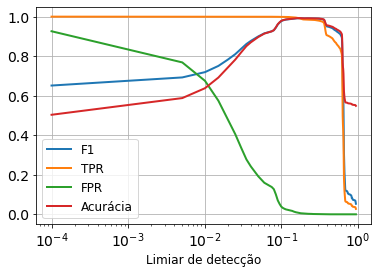

In [120]:
#Metric analyses for the cv dataset for different thresholds
%matplotlib inline
#y_cv_dos == y_cv_prob == y_cv_u2r_r2l
analyseThresholds(y_cv_dos,y_cv_comb_prob,np.arange(1e-4,0.95,5e-3))

In [158]:
y_train_comb_pred = y_train_comb_prob > 0.5
y_cv_comb_pred    = y_cv_comb_prob > 0.25
y_test_comb_pred  = y_test_comb_prob > 0.265

printMetrics([(y_train_dos,y_train_comb_pred),
              (y_cv_dos,y_cv_comb_pred),
              (y_test_dos,y_test_comb_pred)],
             ["Trainning","CV","Test"])

,Trainning,CV,Test
Accuracy,0.998273,0.991308,0.837784
TPR,0.996442,0.983660,0.837217
FPR,0.000130,0.002073,0.161466
AUC,0.998156,0.990793,0.837875
F1 Score,0.998143,0.990566,0.854564
Precisão,0.999850,0.997571,0.872645


In [122]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

eventClasses = ['Normal','R2L']
eventClassesInd = [0,1]

yh_train_comb = yh_train_dos | yh_train_probe | yh_train_u2r_r2l
yh_cv_comb    = yh_cv_dos | yh_cv_probe | yh_cv_u2r_r2l
yh_test_comb  = yh_test_dos | yh_test_probe | yh_test_u2r_r2l

printMetrics([(y_train_dos,yh_train_comb),(y_cv_dos,yh_cv_comb),(y_test_dos,yh_test_comb)],["Trainning","CV","Test"])

,Trainning,CV,Test
Accuracy,0.999305,0.992102,0.852333
TPR,0.998850,0.996407,0.912102
FPR,0.000297,0.011624,0.226650
AUC,0.999276,0.992391,0.842726
F1 Score,0.999254,0.991529,0.875500
Precisão,0.999659,0.986699,0.841723


# Classificação Binária (Ataque - Normal)

## Random Forest

In [159]:
(x_train_bin, y_train_bin) = (df_train_ar.loc[:, filtered_features], df_train_ar.class2)

(x_cv_bin, y_cv_bin) = (df_cv_ar.loc[:, filtered_features], df_cv_ar.class2)

(x_test_bin, y_test_bin) = (df_test_ar.loc[:, filtered_features], df_test_ar.class2)

In [202]:
(x_train_bin, y_train_bin) = (df_train_sc[features_sc], df_train_sc.class2)

(x_cv_bin, y_cv_bin) = (df_cv_sc[features_sc], df_cv_sc.class2)

(x_test_bin, y_test_bin) = (df_test_sc[features_sc], df_test_sc.class2)

In [188]:
(x_train_bin, y_train_bin) = (df_train_complete[features_sc], df_train_complete.class2)

(x_cv_bin, y_cv_bin) = (df_cv_sc[features_sc], df_cv_sc.class2)

(x_test_bin, y_test_bin) = (df_test_sc[features_sc], df_test_sc.class2)

In [189]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=400, max_depth=20, random_state=10000)
rf_clf.fit(x_train_bin,y_train_bin)

beep()

In [190]:
yprob_train_bin = rf_clf.predict_proba(x_train_bin)[:,1]
yprob_cv_bin    = rf_clf.predict_proba(x_cv_bin)[:,1]
yprob_test_bin  = rf_clf.predict_proba(x_test_bin)[:,1]

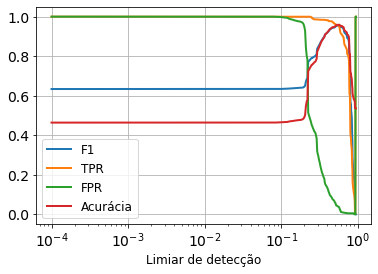

In [191]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, f1_score, precision_score

#Metric analyses for the cv dataset for different thresholds
%matplotlib inline
analyseThresholds(y_cv_bin,yprob_cv_bin,np.arange(1e-4,0.95,5e-3))

In [201]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score

yh_train_bin = yprob_train_bin > 0.5
yh_cv_bin    = yprob_cv_bin > 0.25
yh_test_bin  = yprob_test_bin > 0.35

printMetrics([(y_train_bin,yh_train_bin),(y_cv_bin,yh_cv_bin),(y_test_bin,yh_test_bin)],["Trainning","CV","Test"])

,Trainning,CV,Test
Accuracy,0.999738,0.756341,0.822170
TPR,0.999557,0.996920,0.821086
FPR,0.000104,0.451873,0.176398
AUC,0.999726,0.772523,0.822344
F1 Score,0.999719,0.791510,0.840171
Precisão,0.999881,0.656285,0.860163


## Rede Neural<a id='nn_bin'></a>

### Treinamento

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
'''
nnclass_bin     = Sequential([Dense(1024, activation="relu"),
                              BatchNormalization(),
                              Dropout(0.01),
                              Dense(768, activation="relu"),
                              BatchNormalization(),
                              Dropout(0.01),
                              Dense(512, activation="relu"),
                              BatchNormalization(),
                              Dropout(0.01),
                              Dense(256, activation="relu"),
                              BatchNormalization(),
                              Dropout(0.01),
                              Dense(128, activation="relu"),
                              BatchNormalization(),
                              Dropout(0.01),
                              Dense(1, activation="sigmoid")])

metrics = ["accuracy"]
nnclass_bin.compile(loss="binary_crossentropy", optimizer="adam", metrics=metrics)

epochs = 500
verbose=1
history_bin = nnclass_bin.fit(x_train_bin,y_train_bin, epochs=epochs, batch_size=64, verbose=verbose)
'''
None

In [ ]:
nnclass_bin     = Sequential([Dense(1024, activation="relu"),
                              BatchNormalization(),
                              Dropout(0.01),
                              Dense(1, activation="sigmoid")])

metrics = ["accuracy"]
nnclass_bin.compile(loss="binary_crossentropy", optimizer="adam", metrics=metrics)

epochs = 2
verbose=1
history_bin = nnclass_bin.fit(x_train_bin,y_train_bin, epochs=epochs, batch_size=64, verbose=verbose)

### Avaliação

In [ ]:
from sklearn.metrics import f1_score, precision_recall_fscore_support

eventClasses = ['Normal','Ataque']
eventClassesInd = [0,1]

threshold = 0.1
yh_test_bin = (nnclass_bin.predict(x_test_bin) > threshold).astype(int)
#yh_test_bin = np.argmax(yh_test_bin,axis=1)

yh_train_bin = (nnclass_bin.predict(x_train_bin) > threshold).astype(int)
#yh_train_bin = np.argmax(yh_train_bin,axis=1)

#Acuracia
accTrain = accuracy_score(y_train_bin,yh_train_bin)
accTest = accuracy_score(y_test_bin,yh_test_bin)

#Recall
recTrain = recall_score(y_train_bin,yh_train_bin)
recTest  = recall_score(y_test_bin,yh_test_bin)

#Precision
precTrain = precision_score(y_train_bin,yh_train_bin)
precTest  = precision_score(y_test_bin,yh_test_bin)

#f1 score
f1Train = f1_score(y_train_bin,yh_train_bin)
f1Test  = f1_score(y_test_bin,yh_test_bin)

trainMetrics = np.array([accTrain, recTrain, precTrain, f1Train])
testMetrics  = np.array([accTest, recTest, precTest, f1Test])

table = pd.DataFrame()
table['Treinamento'] = trainMetrics
table['Teste'] = testMetrics
table.index = ["Acurácia", "Revocação", "Precisão","F1 Score"]
table

In [ ]:
pd.crosstab(y_test_bin, yh_test_bin.flatten(), rownames=['Actual attacks'], colnames=['Predicted attacks'])